**Progetto Machine Learning**

Partecipanti
- Fiorentini Nicolò  933157
- Roncoroni Samuele 935111

In questo progetto si analizza l'impatto della contaminazione dei dati sulle prestazioni dei modelli di machine learning. Dopo aver selezionato un dataset adeguato, si esegue un’analisi esplorativa e si scelgono due modelli (per classificazione o regressione). I modelli vengono inizialmente addestrati su dati puliti per stabilire una baseline. Successivamente, si introduce contaminazione progressiva nei dati tramite tecniche controllate. Infine, si valutano le prestazioni dei modelli per identificare le feature più influenti e gli effetti del rumore.

In questa situazione, non si sta cercando di fare un modello perfetto, ma di capire quanto un modello è robusto a diverse quantità di rumore introdotte artificialmente. È quindi un esperimento comparativo e controllato.

#Dataset

In [20]:
#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sn
import requests
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np

url = "https://raw.githubusercontent.com/NIKFIORE/Progetto-Machine-Learning/refs/heads/main/Dataset/Cancer_Data.csv"
# Carica il dataset direttamente da GitHub
df = pd.read_csv(url)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Esplorazione dei Dati (EDA)

Analizza la distribuzione delle feature, la presenza di valori mancanti, correlazioni e altre statistiche descrittive utili.

In [21]:
print(f"Numero di istanze nel dataset: {df.shape[0]}")

Numero di istanze nel dataset: 569


 📈 Ingrandimento del dataset

L’ingrandimento del dataset non è stato effettuato, in quanto le 569 istanze originali risultano sufficienti per lo scopo dello studio, che è analizzare l’effetto progressivo del rumore sulle performance del modello. Aumentare artificialmente le istanze avrebbe introdotto variabilità non controllata, con il rischio di mascherare gli effetti del rumore stesso. Si è preferito quindi mantenere il dataset originale per garantire coerenza e semplicità nell’analisi.


In [22]:
df.drop(columns=["id"], inplace= True)
df.drop(columns=["Unnamed: 32"], inplace= True)
df.dtypes

,0
diagnosis,object
radius_mean,float64
texture_mean,float64
perimeter_mean,float64
area_mean,float64
smoothness_mean,float64
compactness_mean,float64
concavity_mean,float64
concave points_mean,float64
symmetry_mean,float64


In [23]:
#controllo il numero di valori duplicati
df.duplicated().sum().item()

0

In [24]:
# Verifico se ci sono valori mancanti
missing_value = df.isnull().values.any()

# Definisco x prima di usarlo
if not missing_value:
    x = "non"
else:
    x = ""

print(f"Questo dataset {x} ha valori mancanti")

Questo dataset non ha valori mancanti


In [25]:
# Controlla i valori unici nella colonna 'diagnosis'
print(df['diagnosis'].unique())

['M' 'B']


In [26]:
# Mappatura della colonna 'diagnosis'
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [27]:
# Rimuove la variabile target
df_features_only = df.drop(columns=['diagnosis'])

# Ottieni automaticamente tutte le features numeriche (float)
numeric_features = df_features_only.select_dtypes(include=['float64', 'float32']).columns.tolist()
target = "diagnosis"

print(f"Features numeriche trovate: {numeric_features}")
print(f"Numero di features: {len(numeric_features)}")

Features numeriche trovate: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Numero di features: 30


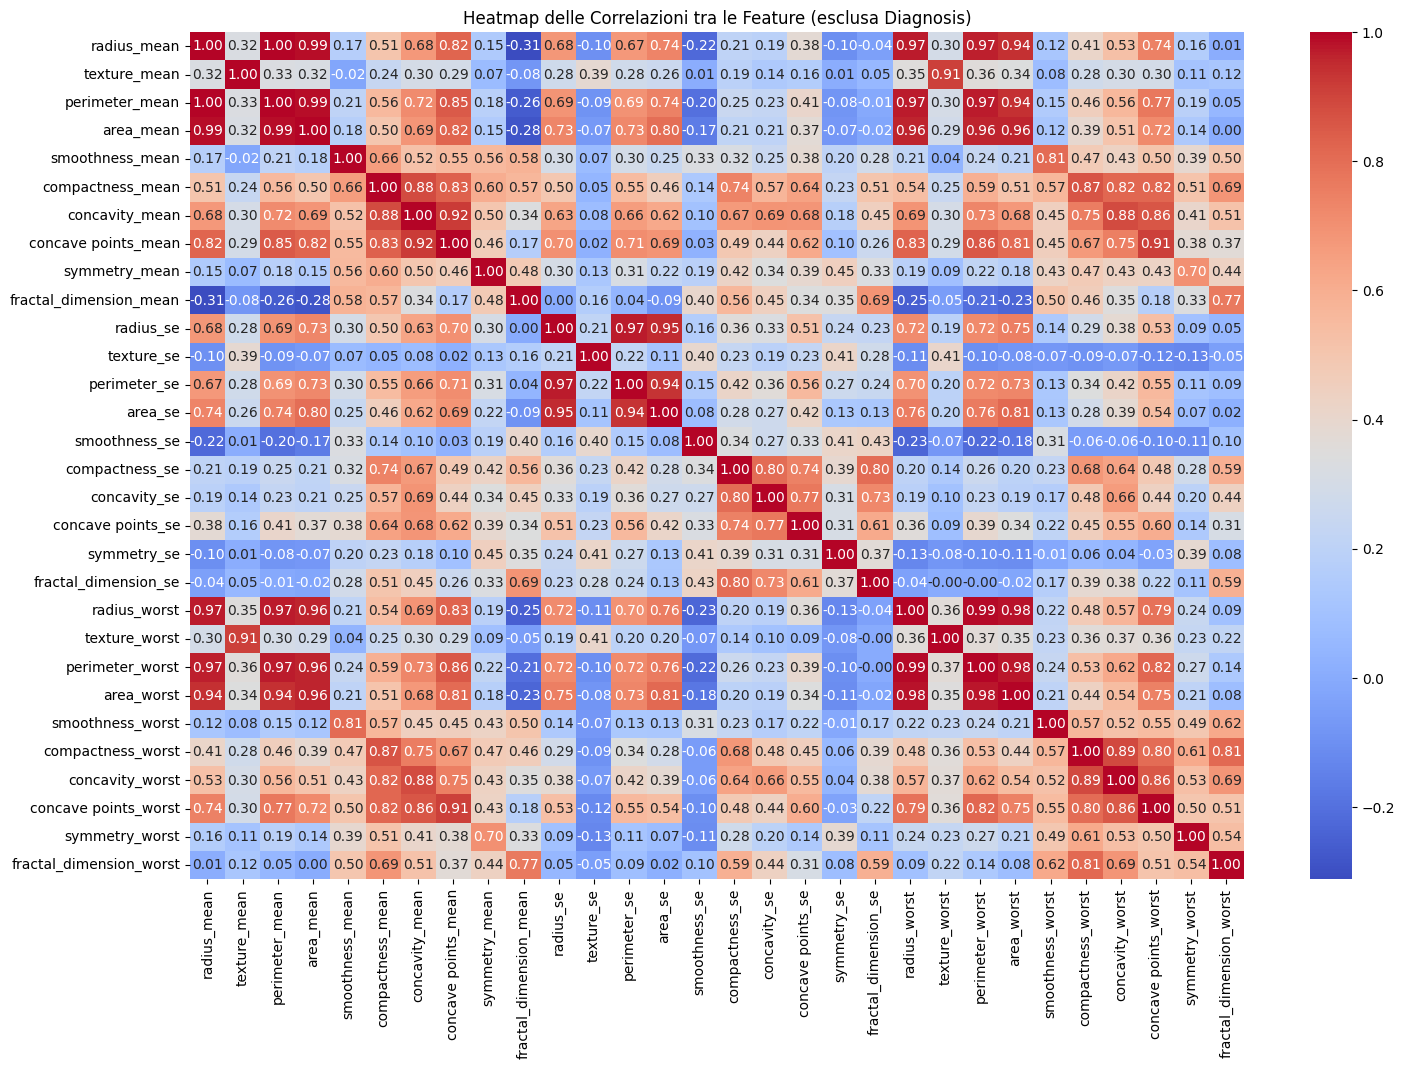

In [28]:
# Calcola la matrice di correlazione
correlation = df_features_only.corr()

# Crea la heatmap completa
plt.figure(figsize=(17, 11))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap delle Correlazioni tra le Feature (esclusa Diagnosis)')
plt.show()

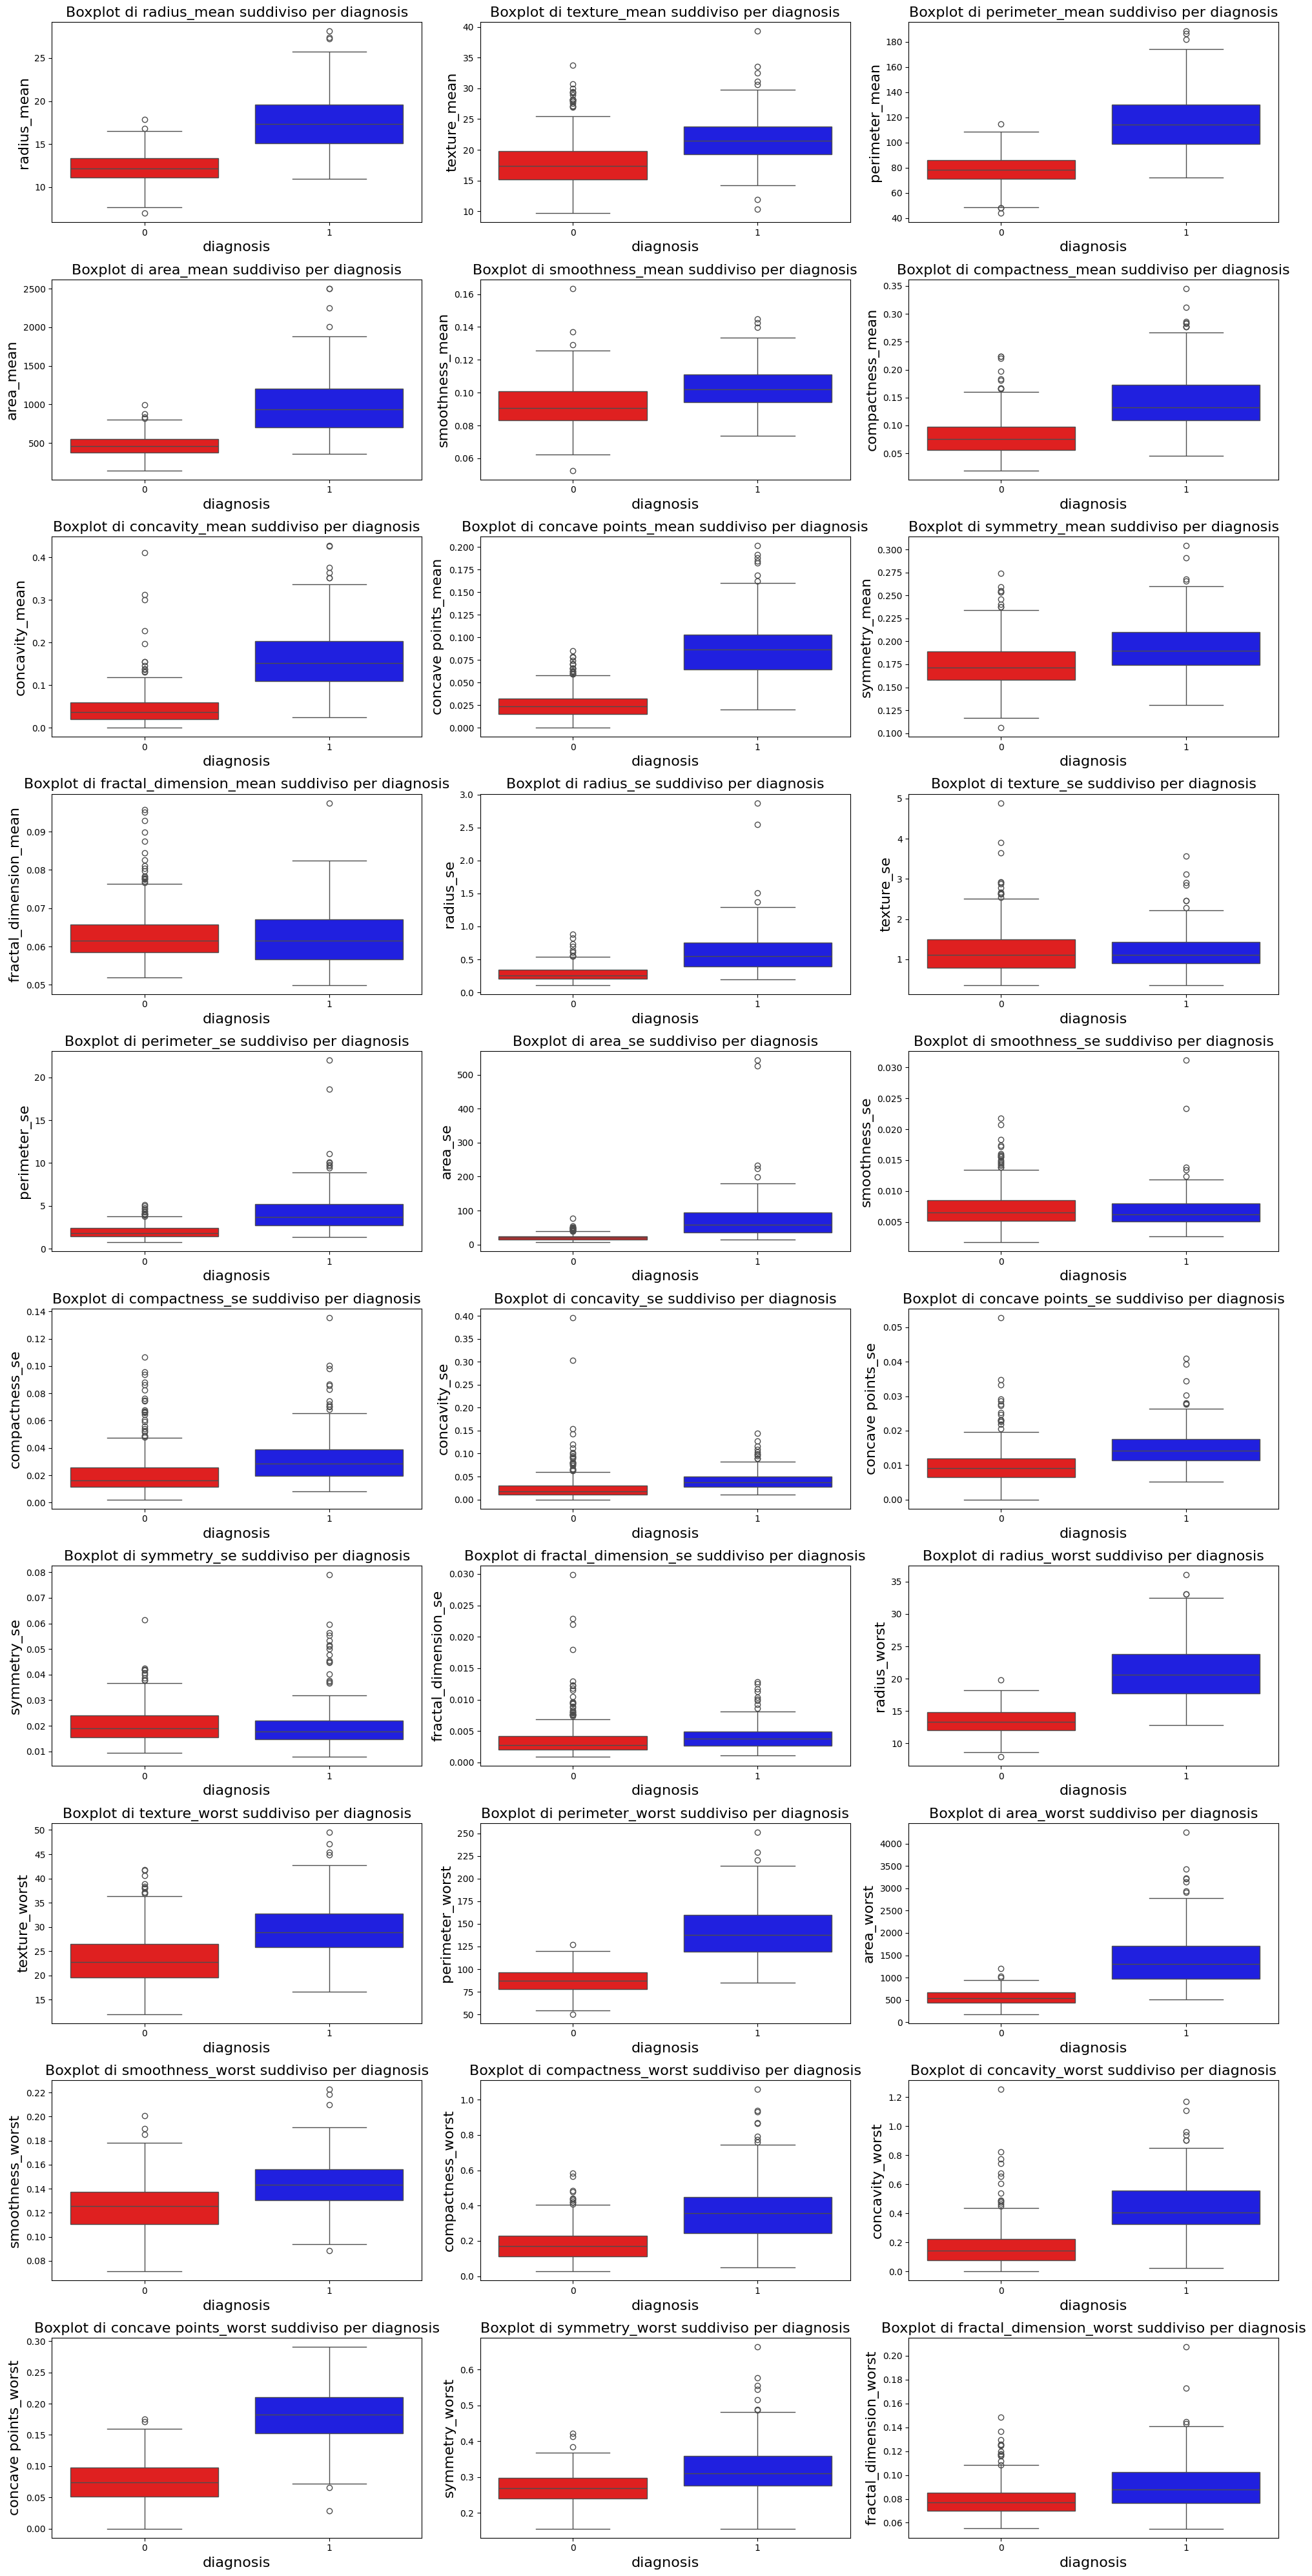

In [29]:
# Calcola il numero di righe e colonne per la griglia
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Calcolo del numero di righe necessarie

# BOXPLOT
plt.figure(figsize=(20, 4 * n_rows))  # Altezza dinamica basata sul numero di righe
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=target, y=feature, data=df, hue=target, palette=['red', 'blue'], legend=False)
    plt.title(f'Boxplot di {feature} suddiviso per {target}', fontsize=16)
    plt.xlabel(target, fontsize=16)
    plt.ylabel(feature, fontsize=16)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')

plt.tight_layout()
plt.savefig("Boxplot_Features_Numeriche.pdf")
plt.show()

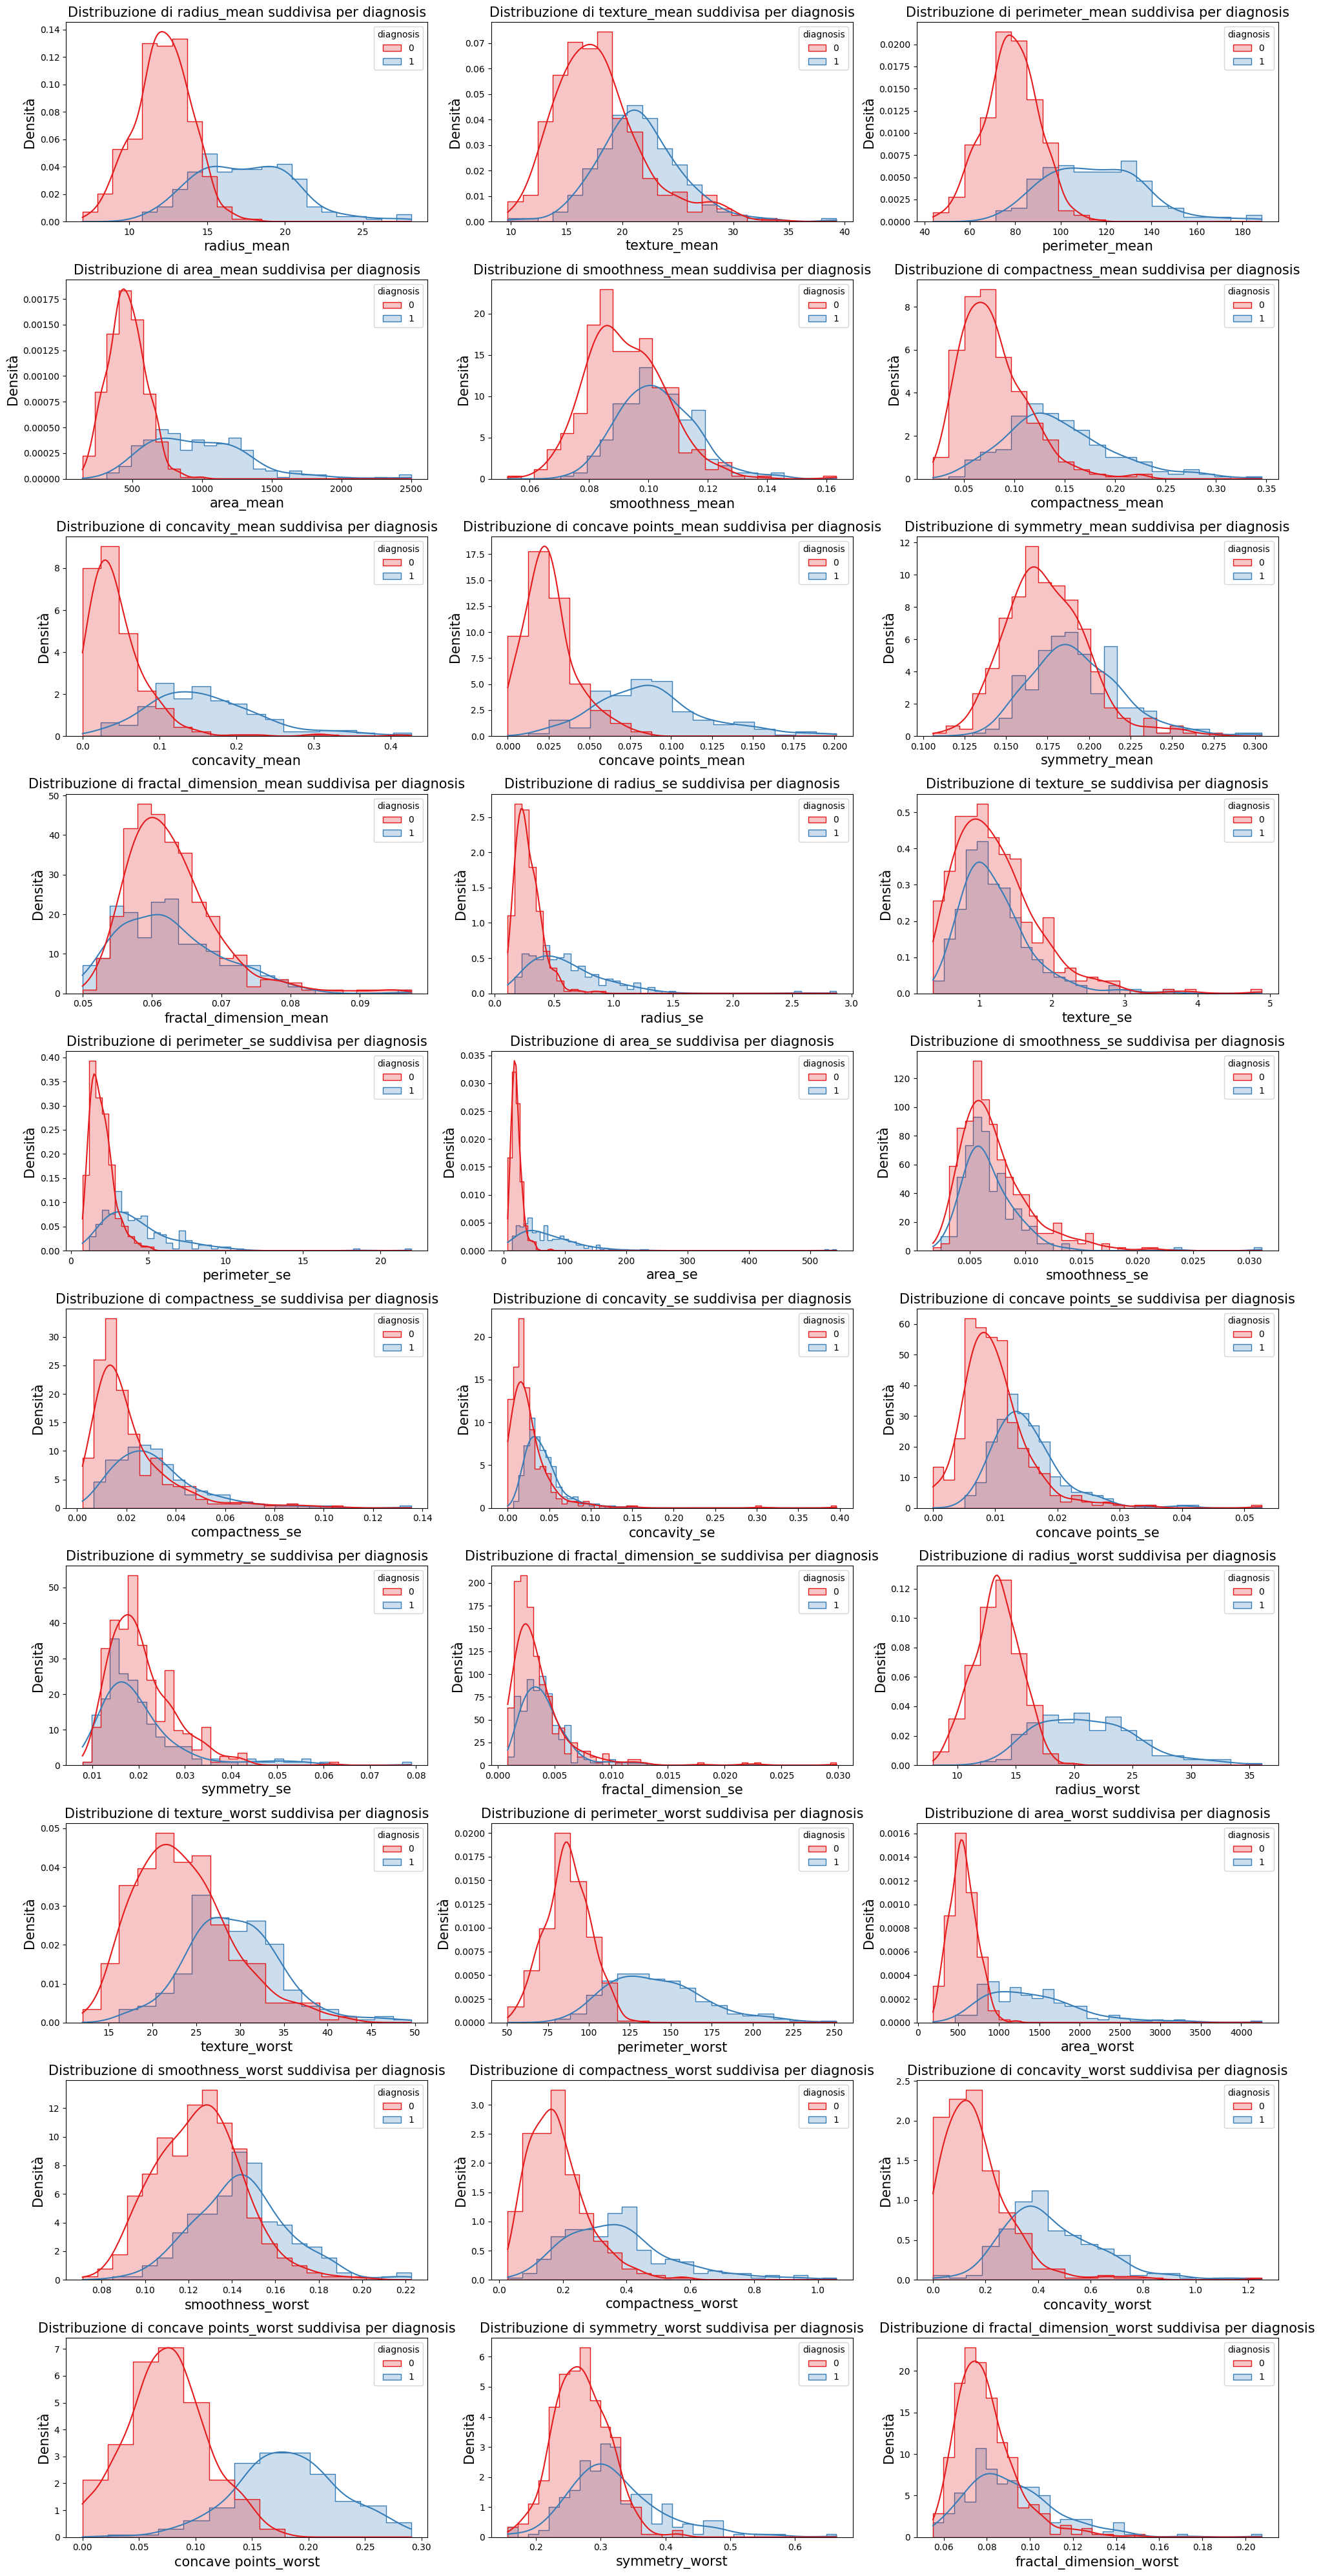

In [30]:
# GRAFICI DI DISTRIBUZIONE
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=False)

# Gestisci il caso di una sola riga
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df, x=feature, hue=target, kde=True, element="step",
                palette="Set1", stat="density", ax=axes[i])
    axes[i].set_title(f"Distribuzione di {feature} suddivisa per {target}", fontsize=15)
    axes[i].set_xlabel(feature, fontsize=15)
    axes[i].set_ylabel("Densità", fontsize=15)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("Distribuzione_Features_Numeriche.pdf")
plt.show()

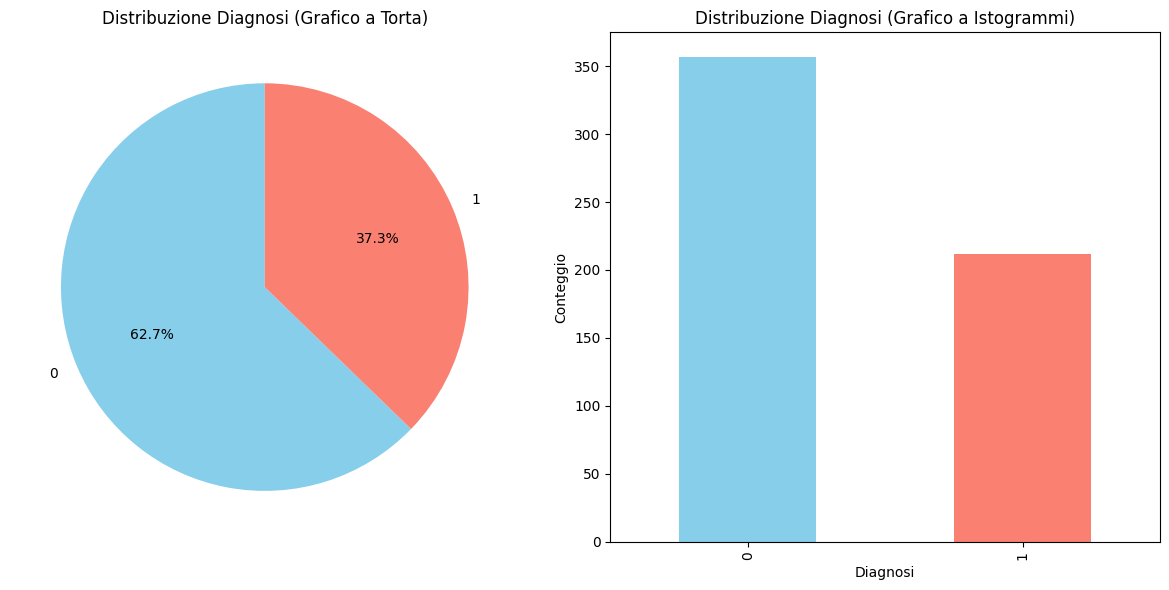

In [31]:
# Plot a torta
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico a torta
plt.subplot(1, 2, 1)
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Torta)')
plt.ylabel('')

# Subplot 2: Grafico a istogrammi
plt.subplot(1, 2, 2)
df['diagnosis'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Istogrammi)')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

# Mostra il grafico
plt.tight_layout()
plt.show()

⚖️ Bilanciamento del target

Il dataset originale presenta una leggera asimmetria tra classi: circa il 62,7% delle istanze sono benigne, mentre il 37,3% sono maligne. Questo sbilanciamento può influenzare negativamente l’apprendimento del modello, portandolo a privilegiare la classe maggioritaria e falsando metriche come l'accuracy. In uno studio volto a valutare la sensibilità del modello al rumore, è fondamentale che le condizioni iniziali siano equilibrate, per evitare che il degrado delle performance sia attribuibile allo sbilanciamento piuttosto che al rumore stesso. Per questo, il bilanciamento del target è stato considerato un passo essenziale, realizzato tramite tecniche di oversampling come SMOTE, al fine di garantire una valutazione imparziale e significativa.


Come bilanciare il target (M/B)?
Tre strategie principali:

- Undersampling: riduci i benigni (B) → perdi informazione.

- Oversampling: duplichi i maligni (M) → rischio overfitting.

- SMOTE (Synthetic Minority Over-sampling Technique): genera nuovi esempi maligni interpolando tra quelli esistenti → consigliato.

# Applicazione dei modelli

In [32]:
# Droppiamo la variabile target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# dividi il dataset in training e validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Funzione che crea e addestra i modelli

In [33]:
# Neural Network model
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),  # Use Input layer instead of specifying input_shape in Dense
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# SVM Model
def create_and_train_svm_model(X_train, y_train, kernel='rbf', C=1):
    model = SVC(kernel=kernel, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Decision Tree Model
def create_and_train_decision_tree(X_train, y_train, random_state=42, **kwargs):
    model = DecisionTreeClassifier(random_state=random_state, **kwargs)
    model.fit(X_train, y_train)
    return model

Funzione per misurare e visionare le performance dei modelli

In [34]:
def evaluate_model_performance(y_true, y_pred, model_name):
    """
    Comprehensive model performance evaluation

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model

    Returns:
    - Dictionary of performance metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print detailed classification report
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred))

    # Return metrics for visualization
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0,0],
        'False Positives': cm[0,1],
        'False Negatives': cm[1,0],
        'True Positives': cm[1,1]
    }

In [35]:
# Comprehensive Metrics Visualization
def plot_model_performance_metrics(metrics_list):
    """
    Create a comprehensive visualization of model performance metrics
    """
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Set up the plot with more precise layout
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')

    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']  # More distinct colors

    # Performance Metrics Bar Plot
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # Create bar plot with enhanced styling
        bars = metrics_df.plot(kind='bar', x='Model', y=metric, ax=ax, color=colors[i],
                                edgecolor='black', linewidth=1, alpha=0.7)

        # Styling improvements
        ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)
        ax.set_ylabel(metric, fontweight='bold')
        ax.set_xlabel('')

        # Customize y-axis to show more precise scale
        ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        # Add value labels on top of bars with more precision
        for j, v in enumerate(metrics_df[metric]):
            ax.text(j, v, f'{v:.4f}', ha='center', va='bottom',
                    fontweight='bold', fontsize=10)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Enhanced Confusion Matrix Visualization
    plt.figure(figsize=(16, 7))

    # True Positives and True Negatives
    plt.subplot(1, 2, 1)
    true_plot = metrics_df.plot(kind='bar', x='Model', y=['True Positives', 'True Negatives'],
                    ax=plt.gca(), color=['#e74c3c', '#3498db'],
                    edgecolor='black', linewidth=1, alpha=0.7)
    plt.title('True Positives and True Negatives', fontweight='bold')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for container in true_plot.containers:
        true_plot.bar_label(container, fmt='%.0f', fontweight='bold')

    # False Positives and False Negatives
    plt.subplot(1, 2, 2)
    false_plot = metrics_df.plot(kind='bar', x='Model', y=['False Positives', 'False Negatives'],
                    ax=plt.gca(), color=['#2ecc71', '#f39c12'],
                    edgecolor='black', linewidth=1, alpha=0.7)
    plt.title('False Positives and False Negatives', fontweight='bold')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for container in false_plot.containers:
        false_plot.bar_label(container, fmt='%.0f', fontweight='bold')

    plt.tight_layout()
    plt.show()

Applicazione dei metodi

In [36]:
# Train Neural Network
input_shape = (X_train.shape[1],)
nn_model = create_neural_network_model(input_shape)
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

# Predict Neural Network
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_metrics = evaluate_model_performance(y_test, nn_pred, 'Neural Network')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Neural Network - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        71
           1       0.89      0.98      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



In [37]:
# Train SVM
svm_model = create_and_train_svm_model(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_metrics = evaluate_model_performance(y_test, svm_pred, 'SVM')


SVM - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        71
           1       1.00      0.86      0.93        43

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



In [38]:
# Train Decision Tree
dt_model = create_and_train_decision_tree(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_metrics = evaluate_model_performance(y_test, dt_pred, 'Decision Tree')


Decision Tree - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



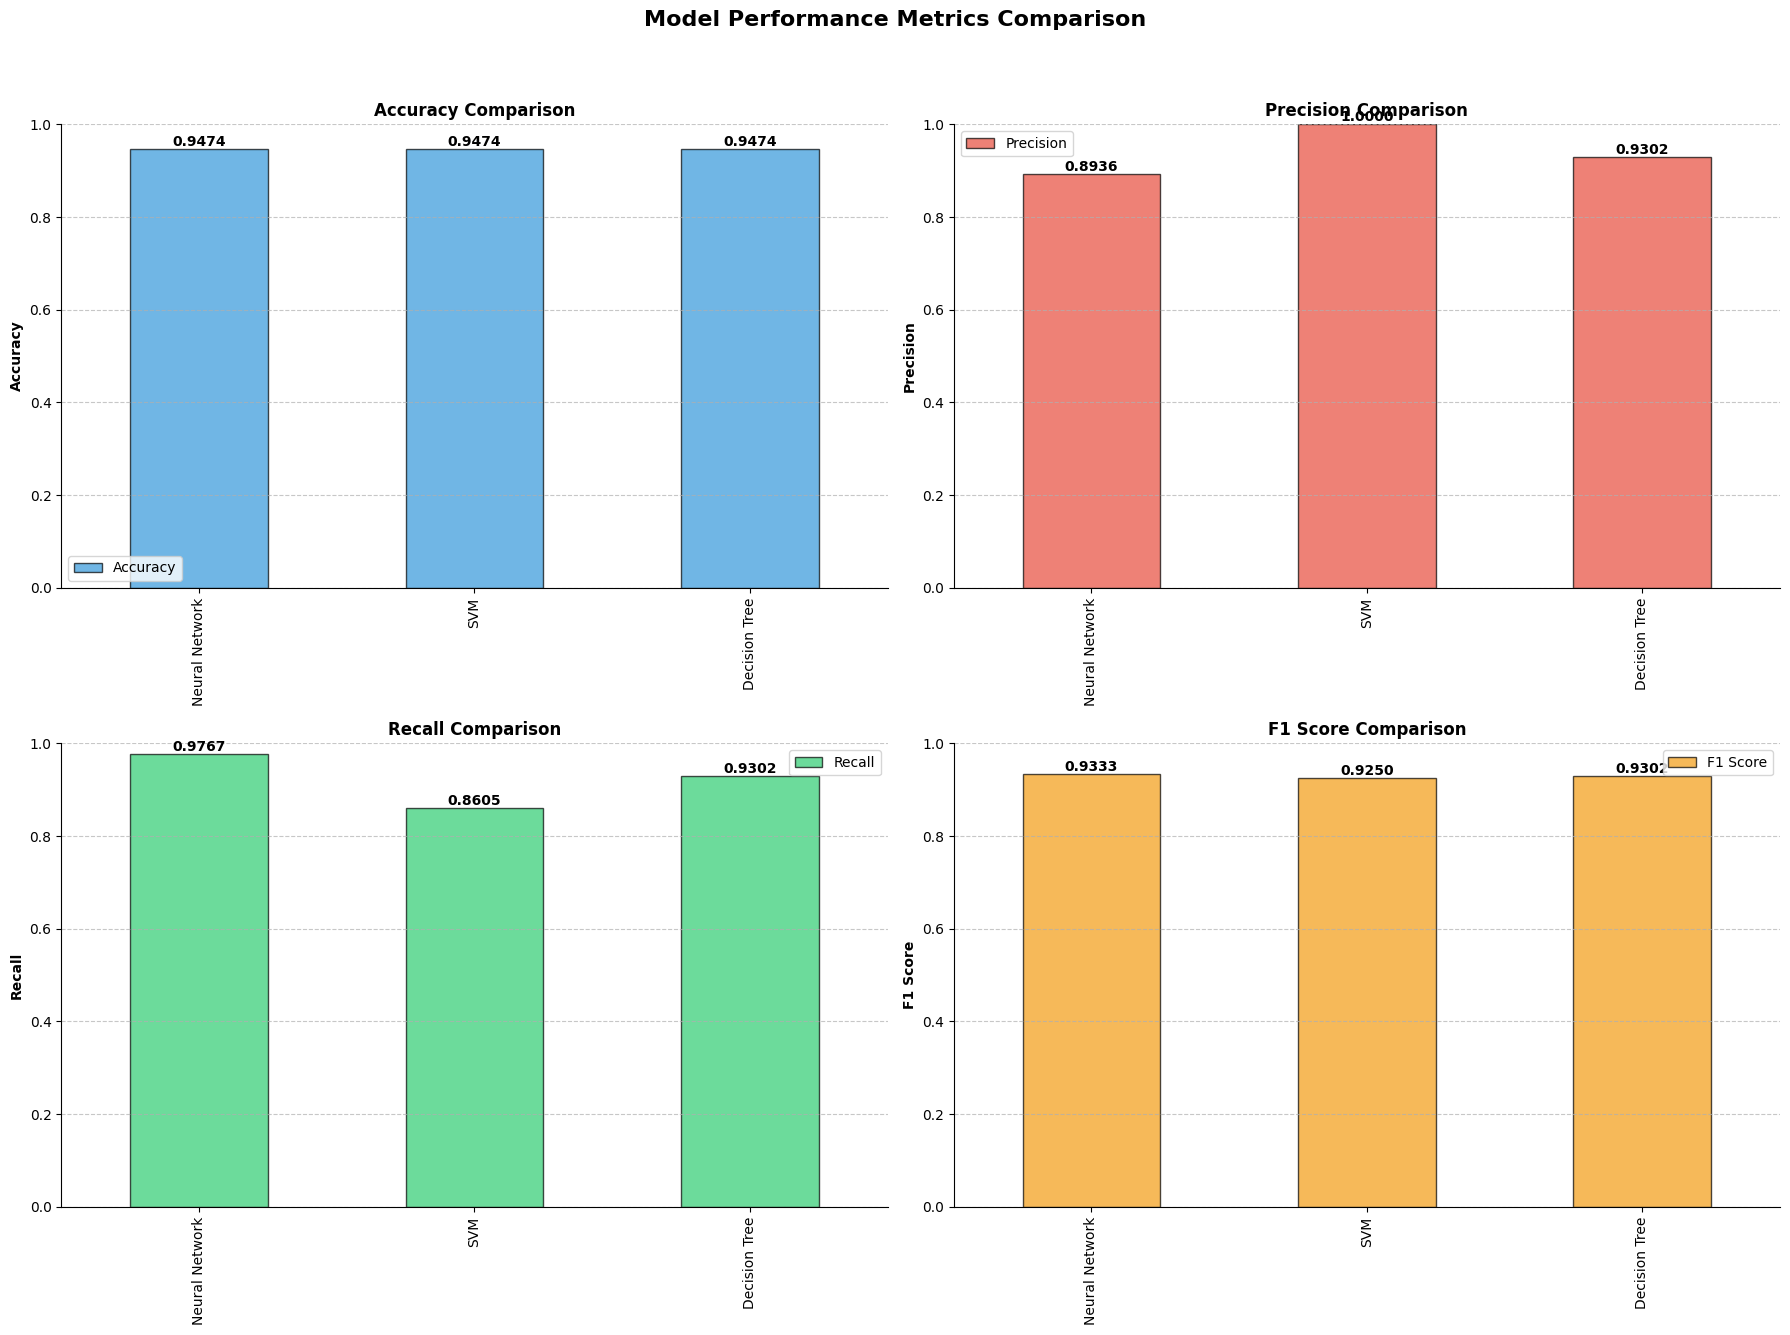

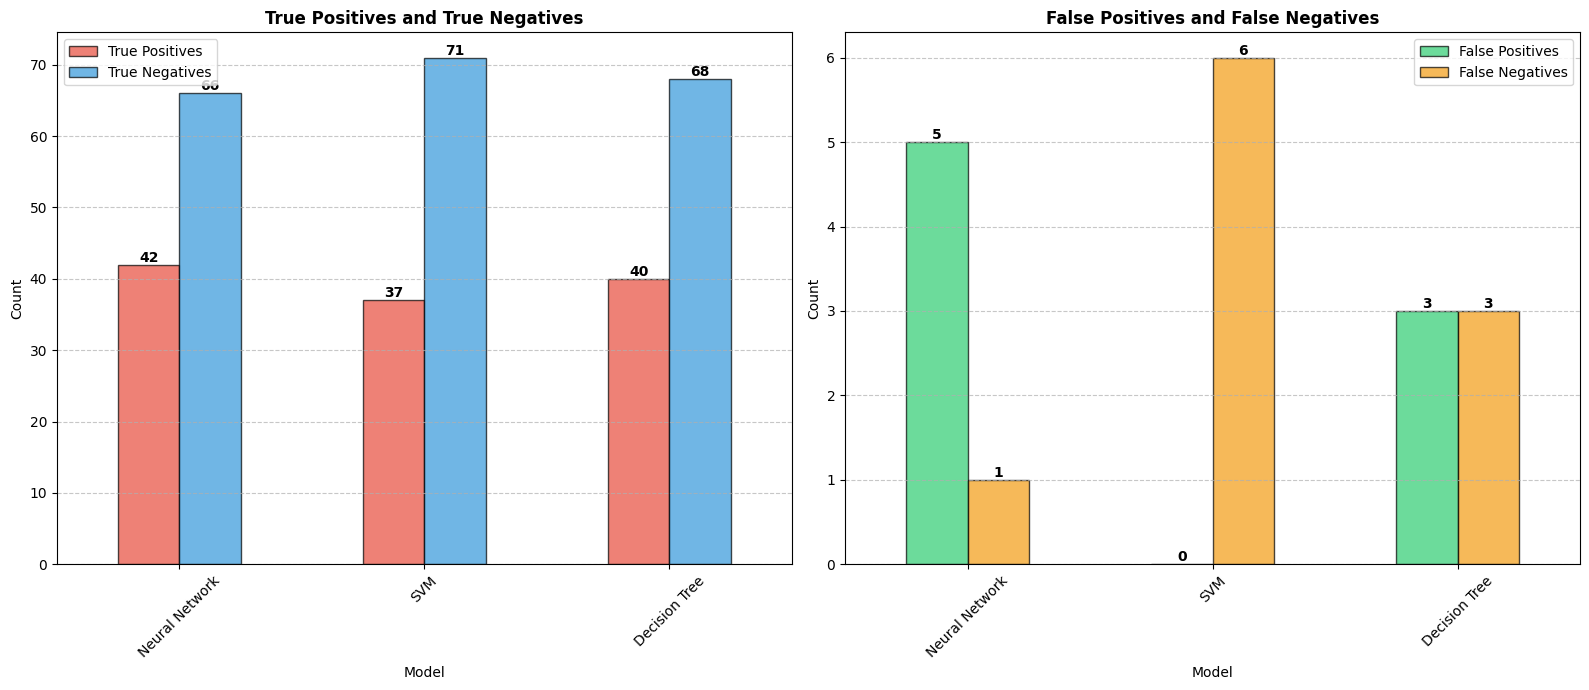

In [39]:
# Visualize Performance Metrics
plot_model_performance_metrics([nn_metrics, svm_metrics, dt_metrics])

# Sporcamento del dataset e analisi degli effetti

Operzioni da svolgere
- rumori
- outliers
- valori nulli
- missing values

fare grafici con percentuale di sporcamento, tipologia di sporcamento e tipologia di elemento su cui viene applicato.